In [1]:
import os 
# 设置工作目录
path = os.path.dirname(os.path.abspath('FireBall_model.ipython'))
os.chdir(path)

In [2]:

# import basic 
import numpy as np
from imp import reload
import pandas as pd 


# machine learning 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score

# visual
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

# import third-party
import pandas as pd 
from sklearn.externals import joblib

# visual
import matplotlib.pyplot as plt
%matplotlib inline

# import local file
import data_clean as dc 
def my_custom_scorer(y_true, y_pred):
    return recall_score(y_true, y_pred, average='micro')

In [ ]:
# 04 - 19
# problems: 
# 1、重新提取数据窗口时间
    # solutions - 原则是尽量选择不涉及重大活动的时间段
# 2、模型存在过拟合问题
#   # solutions - 调参

## 工作流程

1、读取已有的X， y数据集

2、数据预处理

    2.1 剔除X中数字变量的异常值
    2.2 剔除X中分类变量的异常值
      
3、特征工程

4、训练模型

5、保存模型

### 1、读取特征值

In [3]:
# input
# files: "output/extract_result.csv", "output/new_3days_y_2018-03-24.csv"
X = pd.read_csv("output/extract_result.csv", index_col=0).drop(['actions'], axis=1).drop_duplicates('userid', keep='first')
y = pd.read_csv("output/new_3days_y_2018-03-24.csv", index_col=0).drop_duplicates('full_id', keep='first')

# output 
# X, y

### 2、数据预处理部分

#### 2.1 剔除X中数字变量的异常值

In [4]:
# 问题列
# 目的：删除明显不合理的数据
# 结果：各列存在问题，及处理措施，如下

# 1、SignIn 
#    取值为 0 或 1，但是取值为2的显然不合理
#    next - 剔除这部分数据
# 2、unsub
#    取值达到173，明显不合理
#    next - 剔除末端0.1%的用户
# 3、sub
#    同上
#    next - 剔除末端0.1%的用户
# 4、purchase 
#    同上
#    next - 剔除末端0.1%的用户
# 5、share
#    同上
#    next - 剔除末端0.1%的用户
# 6、favorite
#    同上 
#    next - 剔除末端0.1%的用户
# 7、read
#    同上 
#    next - 剔除末端1%的用户
# 8、path3, path4, path5, path6
#   以上路径max值也为0
#    next - 直接剔除
# 9、pathX 与 其他变量非缺失值数量不同
#    next - 是由于抽取规则导致的 - 对于缺失值统一填补上0即可
# 10、default_buyer
# default_buyer为正常的缺失，因为已经筛选掉部分老用户，另外有超过12的默认
#    next - 所以只需补上缺失即可 - 提取众数补上
#         - 超过12的默认修改为12（不一定正确，最好看下confluence上默认关注名单数）

# 注意：具体临界值设置在哪里，最好与业务或BI这边对一遍，按照他们的感觉，划分一个临界
# 如果结果不太理想，可以尝试用聚类 或者 高斯分布剔除异常值

# 导入本地数据清洗库
import data_clean as dc
dc_dc = dc.data_clean()

# 执行异常值剔除工作
# X - numeric 变量
reload(dc)
columns_filterd_one = ['SignIn', 'unsub', 'sub', 'purchase', 'share', 'favorite']
columns_filterd_second = ['read']
X = dc_dc.X_numberic_outlier(X, columns_filterd_one, .999, columns_filtered_second = columns_filterd_second, \
                       critical_percent_second = .99, case_one=True)

In [5]:
# 检验处理后结果
X.describe()

,completed_info,SignIn,weekend,coin,lucky_money,unsub,sub,default_buyer,today_read,purchase,share,favorite,read,path1,path2
count,66861.000000,66861.000000,66861.000000,66861.000000,66861.000000,66861.000000,66861.000000,66861.000000,66861.000000,66861.000000,66861.000000,66861.000000,66861.000000,66861.000000,66861.000000
mean,0.018606,0.295329,0.329594,0.064298,0.066855,0.258387,0.556049,12.742331,5.371861,0.162771,0.160781,1.479592,12.802067,3.082963,0.039754
std,0.135129,0.456194,0.470069,0.245284,0.249773,1.467588,2.403866,1.455466,5.310524,0.479018,0.740273,4.314248,19.895511,7.962893,0.229200
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,3.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,14.000000,11.000000,0.000000,0.000000,1.000000,16.000000,2.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,15.000000,55.000000,16.000000,15.000000,6.000000,13.000000,67.000000,126.000000,143.000000,6.000000


#### 2.2 X分类变量处理

In [6]:
reload(dc)
dc_dc = dc.data_clean()
X_train, X_test, y_train, y_test = dc_dc.X_object_preprocessing(X,y)

/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [7]:
# 检验剔除效果(categorical variabels) - ok
X_test.describe(include=['O'])
X_train.describe(include=['O'])

,userid,os,city,gender,status,date,fromchannel
count,46800,46800,46800,46800,46800,46800,46800
unique,46800,2,3,2,2,29,4
top,5aafab48cf00aa49790c7933,iOS,first,female,worker,2018-03-17,iOS_plat
freq,1,23799,21315,30260,23921,3626,23084


### 3、特征工程

- 1、共线性筛查（>0.6剔除）

- 2、chi-test statistics 计算自变量重要性

- 3、决策树模型筛选

#### 1、共线性筛查

In [8]:
# 目的：剔除共线性高(>0.6)的变量 
# 结果： 剔除变量"favorite"

# train
X_train = X_train.drop(['favorite'], axis=1)
# test 
X_test = X_test.drop(['favorite'], axis=1)
abs(X_train.corr()) > 0.6

,completed_info,SignIn,weekend,coin,lucky_money,unsub,sub,default_buyer,today_read,purchase,share,read,path1,path2
completed_info,True,False,False,False,False,False,False,False,False,False,False,False,False,False
SignIn,False,True,False,False,False,False,False,False,False,False,False,False,False,False
weekend,False,False,True,False,False,False,False,False,False,False,False,False,False,False
coin,False,False,False,True,False,False,False,False,False,False,False,False,False,False
lucky_money,False,False,False,False,True,False,False,False,False,False,False,False,False,False
unsub,False,False,False,False,False,True,False,False,False,False,False,False,False,False
sub,False,False,False,False,False,False,True,False,False,False,False,False,False,False
default_buyer,False,False,False,False,False,False,False,True,False,False,False,False,False,False
today_read,False,False,False,False,False,False,False,False,True,False,False,False,False,False
purchase,False,False,False,False,False,False,False,False,False,True,False,False,False,False


#### 2、chi-test statistics 计算自变量重要性

In [9]:
# get dummies 
train_userid = X_train.loc[:, 'userid']
test_userid = X_test.loc[:, 'userid']
X_train_dummies = pd.get_dummies(X_train.drop(['userid', 'date'], axis=1))
X_test_dummies = pd.get_dummies(X_test.drop(['userid', 'date'], axis=1))

In [10]:
# 目的：筛选重要特征
# 方法：chi test 
# 筛选标准：p > 0.05 且 scores 比较大
# 结果：X_train_dummies, X_test_dummies, 文章集合页，3列被剔除

from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
K_test = SelectKBest(chi2, k=20).fit(X_train_dummies, y_train)

chi_features = zip(X_train_dummies.columns, K_test.pvalues_, K_test.scores_)
chi_features_sort = sorted(chi_features, key=lambda x: x[1], reverse=False)
chi_features_sort

# 由于pvalues < 0.05, 而且scores相对而言不大，因此拒绝city_first & fromchannel_op_channel
# train
X_train_dummies = X_train_dummies.drop(['city_first', 'fromchannel_op_channel'], axis=1)
# test 
X_test_dummies = X_test_dummies.drop(['city_first', 'fromchannel_op_channel'], axis=1)

In [11]:
chi_features_sort

[('sub', 0.0, 2631.8393366369392),
 ('today_read', 0.0, 8006.8564244462423),
 ('purchase', 0.0, 4021.2840732496716),
 ('share', 0.0, 1427.1573873165648),
 ('read', 0.0, 79921.499239680357),
 ('path1', 0.0, 34058.530667053798),
 ('os_Android', 1.1121256872791445e-95, 430.75687833769928),
 ('os_iOS', 1.5485315206023006e-92, 416.31324671815662),
 ('fromchannel_iOS_plat', 2.426120006884302e-82, 369.48230630599829),
 ('path2', 1.2713859650825601e-71, 320.25995532782883),
 ('fromchannel_goodchannel', 9.3133794216507493e-70, 311.69902245664389),
 ('SignIn', 1.9045833890578993e-64, 287.32327339599931),
 ('completed_info', 2.4535927485851091e-63, 282.22928770255544),
 ('coin', 4.9256547888980642e-29, 125.06492131591372),
 ('unsub', 5.9204974021892536e-27, 115.5643964198149),
 ('lucky_money', 1.1500840898350064e-23, 100.55751428489516),
 ('fromchannel_badchannel', 2.7825157705862943e-20, 85.137998214365425),
 ('city_second', 2.025448028077848e-08, 31.470007197375171),
 ('gender_male', 0.00019102

#### 3、决策树筛选特征

In [12]:
# 目的：筛选重要特征
# 方法：决策树
# 筛选标准：scores明显小于其他列剔除
# 结果：

# scale 
# 归一化
scaler = MinMaxScaler()
scaler.fit(X_train_dummies)
X_train_scaler = scaler.transform(X_train_dummies)
X_test_scaler = scaler.transform(X_test_dummies)

# output 
# X_train_scaler, X_test_scaler, y_train, y_test, model_columns

# input
# X_train_scaler, y_train
# train
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
X, y = X_train_scaler, y_train

clf_fea = ExtraTreesClassifier()
clf_fea.fit(X, y)

# output
# clf_fea
model_columns = X_train_dummies.columns
clf_features = zip(model_columns, clf_fea.feature_importances_)
clf_features_sort = sorted(clf_features, key=lambda x: x[1], reverse=True)
clf_features_sort

# X_train_dummies
dropped_elements = ['fromchannel_iOS_plat', 'fromchannel_badchannel', 'completed_info', 'os_Android', 'default_buyer']
X_train_dummies = X_train_dummies.drop(dropped_elements, axis=1)
# X_test_scaler 
X_test_dummies = X_test_dummies.drop(dropped_elements, axis=1)

In [38]:
X_trian_copy = X_train_dummies.copy()
X_test_copy = X_test_dummies.copy()

In [11]:
X_train_dummies.loc[:, X_train_dummies.dtypes != 'uint8'].shape

(46800, 13)

In [13]:
# clustering
# step1: normalize and scaler
# 归一化
scaler = MinMaxScaler()
scaler.fit(X_train_dummies.loc[:, X_train_dummies.dtypes != 'uint8'])
X_train_cluster = scaler.transform(X_train_dummies.loc[:, X_train_dummies.dtypes != 'uint8'])
X_test_cluster = scaler.transform(X_test_dummies.loc[:, X_test_dummies.dtypes != 'uint8'])

In [14]:
# step2: PCA
from sklearn.decomposition import PCA
def pca_transform(X_train_cluster):
    pca = PCA(n_components=3)
    pca.fit(X_train_cluster)
    kmeans_pca = pca.transform(X_train_cluster)
    print(pca.explained_variance_ratio_)
    return kmeans_pca
pca_trans = pca_transform(X_train_cluster)

[ 0.30492759  0.29146112  0.17825719]


In [ ]:
# step3: find the best k for kmeans
def kmeans_content(X_train_cluster):
    from sklearn.cluster import KMeans
    import seaborn as sns
    import pandas as pd
    # clustering
    m = range(10)
    scores = []
    for i in m:
        kmeans = KMeans(n_clusters=i+2, random_state=0, n_init=10, max_iter=100, n_jobs=2).fit(X_train_cluster)
        scores.append(kmeans.score(X_train_cluster))
    # visual
    #plt_data = pd.DataFrame(np.column_stack((np.add(m,2), scores)), columns=['cluster_size', 'loss'])
    #g = sns.lmplot(x='cluster_size', y='loss', data=plt_data)
    #g.set_axis_labels("number of clusters", "loss")
    return scores
scores = kmeans_content(X_train_cluster)

# output 
# best k is 5 

In [15]:
# step4: get best kmeans result and visual the result
# take optimal
def kmeans_content(X_train_cluster):
    from sklearn.cluster import KMeans
    # clustering
    kmeans = KMeans(n_clusters=4, random_state=8, n_init=500, max_iter=1000).fit(X_train_cluster)
    return kmeans
kmeans = kmeans_content(X_train_cluster)
# output -> kmeans.labels_

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


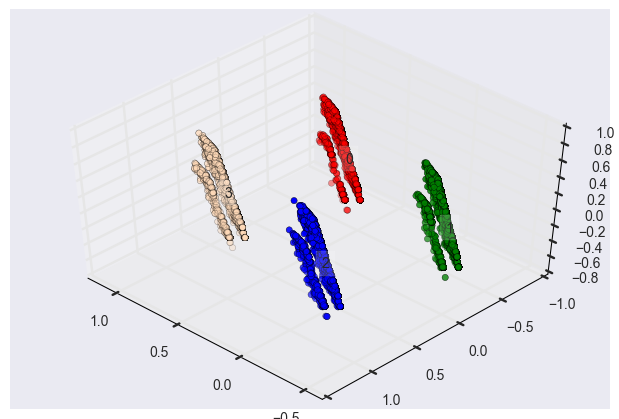

In [49]:
labels = kmeans.labels_
def see_3D(pca_trans, labels):
    import numpy as np
    import matplotlib.pyplot as plt
    #Though the following import is not directly being used, it is required
    # for 3D projection to work
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(1)
    ax = Axes3D(fig, elev=48, azim=134)
    if labels != None:
        len_labels = len(np.unique(labels))
        for label in range(len_labels):
            ax.text3D(pca_trans[labels == label, 0].mean(),
                  pca_trans[labels == label, 1].mean(),
                  pca_trans[labels == label, 2].mean(), label,
              horizontalalignment='center',
              bbox=dict(alpha=.2, edgecolor='w', facecolor='w'))
        # colormap choices 'viridis', 'plasma','inferno', 'magma'
        color_names = ["r", "g", "b", "peachpuff", "fuchsia","orange", "cyan","darkorchid","gold", "yellow","c","purple","pink" ]
        
        # set labels to colors
        labels_to_colors = [color_names[i] for i in labels]
        ax.scatter3D(pca_trans[:, 0], pca_trans[:, 1], pca_trans[:, 2], c=labels_to_colors)
    else:
        ax.scatter3D(pca_trans[:, 0], pca_trans[:, 1], pca_trans[:, 2])
    fig.show()
    plt.savefig('output/fig.png')
# kmeans
see_3D(pca_trans, kmeans.labels_)
# AC_clustering
##see_3D(pca_trans, AC_final.labels_)

In [16]:
# add new y labels 
X_train_dummies['kmeans_labels'] = kmeans.labels_
X_test_dummies['kmeans_labels'] = kmeans.predict(X_test_cluster)

In [17]:
X_train_dummies.loc[:, X_train_dummies.dtypes != 'uint8'].drop(['path2'], axis=1).loc[:, ['sub', 'today_read', 'purchase', 'share', 'read', 'kmeans_labels']].groupby('kmeans_labels').mean()

,sub,today_read,purchase,share,read
kmeans_labels,,,,,
0,0.379291,5.364949,0.109466,0.108541,11.224021
1,0.346880,5.015995,0.103897,0.098265,10.097544
2,0.985501,5.872779,0.302409,0.310149,18.179767
3,1.024649,6.163027,0.292324,0.288000,20.033730


In [23]:
X_train_dummies.loc[X_train_dummies.loc[:, 'kmeans_labels'] == 3].describe()

,SignIn,weekend,coin,lucky_money,unsub,sub,today_read,purchase,share,read,...,path2,os_iOS,city_others,city_second,gender_female,gender_male,status_student,status_worker,fromchannel_goodchannel,kmeans_labels
count,4625.0,4625.0,4625.000000,4625.000000,4625.000000,4625.000000,4625.000000,4625.000000,4625.000000,4625.000000,...,4625.000000,4625.00000,4625.000000,4625.000000,4625.000000,4625.000000,4625.000000,4625.000000,4625.000000,4625.0
mean,1.0,1.0,0.060541,0.130162,0.500324,1.024649,6.163027,0.292324,0.288000,20.033730,...,0.053189,0.38400,0.370595,0.215568,0.660108,0.339892,0.600000,0.400000,0.483459,3.0
std,0.0,0.0,0.238511,0.336518,2.062929,3.056602,5.214248,0.621970,0.981047,26.017897,...,0.260138,0.48641,0.483016,0.411260,0.473723,0.473723,0.489951,0.489951,0.499780,0.0
min,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0
25%,1.0,1.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0
50%,1.0,1.0,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,9.000000,...,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,3.0
75%,1.0,1.0,0.000000,0.000000,0.000000,1.000000,11.000000,0.000000,0.000000,28.000000,...,0.000000,1.00000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0
max,1.0,1.0,1.000000,1.000000,15.000000,55.000000,15.000000,6.000000,13.000000,126.000000,...,3.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0


In [53]:
from sklearn.metrics import euclidean_distances
euclidean_distances(kmeans.cluster_centers_)
# 0-1相似
# 2-3相似

array([[ 0.        ,  1.00042713,  1.41845041,  1.00824653],
       [ 1.00042713,  0.        ,  1.00766907,  1.42187003],
       [ 1.41845041,  1.00766907,  0.        ,  1.000513  ],
       [ 1.00824653,  1.42187003,  1.000513  ,  0.        ]])

In [58]:
X_train_dummies['y'] = y_train

In [62]:
new_retained = X_train_dummies[['kmeans_labels', 'y']].groupby(['kmeans_labels', 'y']).size().unstack(fill_value=0)
new_retained['retained_rate'] = new_retained.loc[:, 1] / (new_retained.loc[:, 0] + new_retained.loc[:, 1])
new_retained

y,0,1,retained_rate
kmeans_labels,,,
0,8505,2302,0.213010
1,17076,5119,0.230638
2,6218,2955,0.322141
3,3253,1372,0.296649


In [65]:
float(new_retained.loc[:, 1].sum())/(new_retained.loc[:, 0].sum() + new_retained.loc[:, 1].sum())

0.251025641025641

In [26]:
# add new columns
X_train_dummies[['kmeans_0', 'kmeans_1','kmeans_2','kmeans_3']] = pd.get_dummies(X_train_dummies.loc[:, 'kmeans_labels'], prefix='labels_')
X_test_dummies[['kmeans_0', 'kmeans_1','kmeans_2','kmeans_3']] = pd.get_dummies(X_test_dummies.loc[:, 'kmeans_labels'], prefix='labels_')

In [27]:
# drop kmeans_labels
X_train_dummies = X_train_dummies.drop('kmeans_labels', axis=1)
X_test_dummies = X_test_dummies.drop('kmeans_labels', axis=1)

### 6、归一化处理

In [28]:
# 归一化
# input 
# X_train_dummies, X_test_dummies, y_train, y_test

# scale 
# 归一化
scaler = MinMaxScaler()
scaler.fit(X_train_dummies)
X_train_scaler = scaler.transform(X_train_dummies)
X_test_scaler = scaler.transform(X_test_dummies)

# save columns 
model_columns = X_train_dummies.columns
np.savetxt('output/model_columns', model_columns, fmt='%s')
# save scaler 
scaler_filename = "output/scaler.save"
joblib.dump(scaler, scaler_filename) 

# output 
# X_train_scaler, X_test_scaler, y_train, y_test, model_columns, scaler

['output/scaler.save']

### 8、训练模型

In [62]:
# input: X_train_f, X_test_f, y_train_f, y_test_f
# outputs: top5 favorited buyers for each user, and sorted by pred_score
# after that: for rest of buyers, give possible love score
from sklearn.ensemble import GradientBoostingClassifier

# Train model
clf = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=4,
              min_samples_split=36, min_weight_fraction_leaf=0.0,
              n_estimators=150, presort='auto', random_state=None,
              subsample=0.7, verbose=0, warm_start=False)

# set parameters
parameters = dict(
    #n_estimators = range(150, 300, 10)
    #learning_rate= [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    #max_depth = range(2, 6, 1)
    #max_leaf_nodes = range(2, 20, 1), 
    #min_samples_split = range(2, 50, 2)
    #subsample = [0.5, 0.6, 0.7, 0.8]
)

# set score function
def my_custom_scorer(y_true, y_pred):
    return f1_score(y_true, y_pred, average='weighted')
scoring = make_scorer(my_custom_scorer)
# set 
estimator = GridSearchCV(clf,parameters, n_jobs=-1, scoring=scoring)

# train
estimator.fit(X_train_scaler, y_train)
 
# predict on test
clf_pred_y = estimator.predict(X_test_scaler)
 
# Is our model still predicting just one class?
# check
print( np.unique( clf_pred_y ) )
 
# How's our accuracy?
#print(accuracy_score(y_test, clf_pred_y))
# 0.9744
 
# What about AUROC?
#prob_y = clf.predict_proba(X_test_scaler)
#prob_y = [p[1] for p in prob_y]
# best params
print "best estimator_rf\n{}\n{}\n\n".format(estimator.best_estimator_, estimator.best_params_)

# 过拟合
print(classification_report(y_train, estimator.predict(X_train_scaler)))
print(classification_report(y_test, clf_pred_y))
#print (classification_report(y, estimator.predict(np.vstack((X_train_scaler,X_test_scaler))))) # favorite 2, recall is not good

[0 1]
best estimator_rf
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=4,
              min_samples_split=36, min_weight_fraction_leaf=0.0,
              n_estimators=150, presort='auto', random_state=None,
              subsample=0.7, verbose=0, warm_start=False)
{}


             precision    recall  f1-score   support

          0       0.79      0.96      0.87     35052
          1       0.66      0.22      0.33     11748

avg / total       0.75      0.78      0.73     46800

             precision    recall  f1-score   support

          0       0.79      0.96      0.87     15059
          1       0.66      0.22      0.32      4999

avg / total       0.75      0.78      0.73     20058



In [82]:
estimator.best_score_

0.71988326984044493

In [80]:
# Train model
clf = RandomForestClassifier(n_estimators=110, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=3, min_weight_fraction_leaf=0.0, max_features='log2', max_leaf_nodes=None, min_impurity_split=0.0, bootstrap=True, oob_score=True, n_jobs=-1, random_state=21, verbose=0, warm_start=False, class_weight='balanced')

# set parameters
parameters = dict(
n_estimators = range(110, 200, 10)
#max_depth = range(1, 6, 1)
#min_samples_split = range(2, 30, 2),
#min_samples_leaf = range(1, 10, 1)
#class_weight = [None]
)

# set score function
scoring = make_scorer(my_custom_scorer)
# set 
estimator = GridSearchCV(clf,parameters, cv = 5, n_jobs=-1, scoring=scoring)

# train
print "训练模型中...."
estimator.fit(X_train_scaler, y_train)
print "训练完成...."

print "预测中...."
# predict on test
clf_pred_y = estimator.predict(X_test_scaler)
 
# best params
print "best estimator_rf\n{}\n{}\n\n".format(estimator.best_estimator_, estimator.best_params_)

# analysis report
print "分析报告生成中....."
print(classification_report(y_train, estimator.predict(X_train_scaler)))
print(classification_report(y_test, clf_pred_y))
print (classification_report(np.concatenate((y_train, y_test), axis=0), estimator.predict(np.vstack((X_train_scaler, X_test_scaler))))) # favorite 2, recall is not good

训练模型中....
训练完成....
预测中....
best estimator_rf
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='log2',
            max_leaf_nodes=None, min_impurity_split=0.0,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=130, n_jobs=-1,
            oob_score=True, random_state=21, verbose=0, warm_start=False)
{'n_estimators': 130}


分析报告生成中.....
             precision    recall  f1-score   support

          0       0.91      0.85      0.88     35052
          1       0.64      0.76      0.69     11748

avg / total       0.84      0.83      0.83     46800

             precision    recall  f1-score   support

          0       0.83      0.78      0.80     15059
          1       0.43      0.51      0.47      4999

avg / total       0.73      0.71      0.72     20058

             precision    recall  f1-score   support

          0       0.89      0.83      0.86     5

In [81]:
estimator.best_score_

0.71988326984044493

### 9、保存模型

In [2]:
# 保存模型到output
joblib.dump(estimator, "output/train_model.m")

NameError: name 'estimator' is not defined

In [21]:
# 恢复模型并做预测
from sklearn.externals import joblib
recoverd_model = joblib.load("output/train_model.m")
print classification_report(y_test, recoverd_model.predict(X_test_scaler))

             precision    recall  f1-score   support

          0       0.84      0.75      0.80     15059
          1       0.43      0.57      0.49      4999

avg / total       0.74      0.71      0.72     20058

